In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T

In [2]:
file_name = 'mimmo/file1000001.h5'
hf = h5py.File(file_name,'r')

print('Keys: ', list(hf.keys()))
print('Attrs: ', dict(hf.attrs),'\n')
print(hf['ismrmrd_header'])
print(hf['kspace'])
print(hf['reconstruction_esc'])
print(hf['reconstruction_rss'])

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs:  {'acquisition': 'CORPDFS_FBK', 'max': 0.000851878253624366, 'norm': 0.0596983310320022, 'patient_id': '0beb8905d9b7fad304389b9d4263c57d5b069257ea0fdc5bf7f2675608a47406'} 

<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (36, 640, 372), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (36, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (36, 320, 320), type "<f4">


In [3]:
volume_kspace = hf['kspace'][()]     #Takes all the kspace
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(36, 640, 372)


In [4]:
#Takes single layer of the kspace image
slice_kspace = volume_kspace[35] #Ogni valore tra 0-35 ritorna un'immagine diversa
print(slice_kspace.shape,volume_kspace.shape)

(640, 372) (36, 640, 372)


(640, 372)


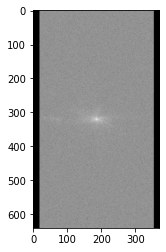

In [5]:
def show_coils(data, cmap=None): #Shows image in kspace
    fig = plt.figure()
    print(data.shape)
    plt.imshow(data, cmap=cmap)
    
show_coils(np.log(np.abs(slice_kspace) + 1e-9),cmap='gray')

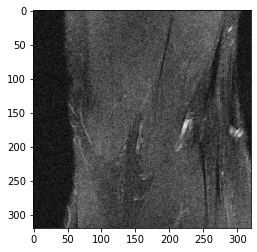

In [6]:
ricostruzione_esc = hf['reconstruction_esc'][35]
fig = plt.figure()
plt.imshow(ricostruzione_esc, cmap='gray') #The real image already reconstructed from kspace (FULLY SAMPLED)

!!! THIS IS THE RELEVANT PART OF THE CODE i.e. FROM KSPACE TO UNDERSAMPLE REAL IMAGE !!!

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CLP_Net(nn.Module):

    def __init__(self):
        super(CLP_Net, self).__init__()
        
        # 1 input image channel, 16 output channels, 4x4 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 16, 5,padding=2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        #x = F.max_pool2d(F.relu(self.conv1(x)), 5) #TODO: FORSE é DA LEVA RELU

        #x = F.interpolate(x,80) #Resizes the image (320x320)/4
        x = F.max_pool2d(x,4)
        x = self.conv1(F.relu(x))
        return x

class Conv_Block_1(nn.Module):
    
    def __init__(self):
        super(Conv_Block_1, self).__init__()
        
        self.resblock = nn.Sequential(
               nn.Conv2d(16,16,5,padding = 2),
               nn.ReLU(),
               nn.Conv2d(16,16,5,padding = 2))
        
    def forward(self, x):
        for i in range (0,16):
            y = self.resblock(x)
            x = y+x
        return x
    
class Conv_Block_2(nn.Module):
    
    def __init__(self):
        super(Conv_Block_2, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.Conv2d(16,16,5,padding = 2),
            nn.ReLU(),
            nn.Conv2d(16,16,5,padding = 2),
            nn.ReLU(),
            nn.Conv2d(16,16,5,padding = 2),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.resblock(x)
    
net = CLP_Net()
print(net)
net2 = Conv_Block_1()
print(net2)
net3 = Conv_Block_2()
print(net3)

CLP_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Conv_Block_1(
  (resblock): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)
Conv_Block_2(
  (resblock): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
  )
)


In [8]:
#Now we want the UNDER SAMPLED real image, so we apply the mask function to the kspace image
from fastmri.data.subsample import RandomMaskFunc
from fastmri.data import subsample
from fastmri.data import transforms, mri_data

#slice_kspace2 = T.to_tensor(slice_kspace)
#print(slice_kspace.shape)
#print(slice_kspace2.shape)

mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

#masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
    return masked_kspace

In [9]:
import pathlib
from pathlib import Path
import experimental.zero_filled
from torchvision.utils import save_image

dataset = mri_data.SliceDataset(
    root=pathlib.Path('mimmo'),
    transform=data_transform,
    challenge='singlecoil'
)

for masked_kspace in dataset:
    sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image = T.complex_center_crop(sampled_image, (320,320))   #We want a 320x320 input
    
    #sampled_image = transforms.tensor_to_complex_np(sampled_image)
    #print(sampled_image.shape)
    #save_image(sampled_image,'pippo.jpg')
    
    #FORSE TOCCA FERMASSE FINO A QUA PER APPLICARE COMPLEX CONVOLUTION
    #FORSE NON CE SERVE L'IMMAGINE REALE
    
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_abs = sampled_image_abs.numpy()
    espandi = np.expand_dims(sampled_image_abs, axis=0)
    espandiDUVORTE = T.to_tensor(np.expand_dims(espandi, axis=0))
    #print(espandiDUVORTE.shape)
    #plt.savefig('pippo.jpg')
    #plt.axis('off') 
    #plt.imshow(sampled_image_abs, cmap='gray') #We got the UNDER SAMPLED image
    
    #img = plt.figure()
    #plt.imshow(espandiDUVORTE[0][0], cmap='gray')

torch.Size([1, 1, 320, 320])
torch.Size([1, 16, 80, 80])
torch.Size([1, 16, 80, 80])
---
---
torch.Size([80, 80])


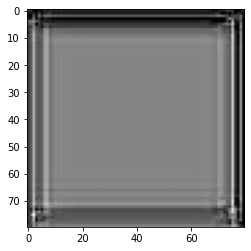

In [10]:
#PROVAMO LA RETE NEURALE

print(espandiDUVORTE.shape) #Input for the 'downsample'

output_4xDownsample = net(espandiDUVORTE)  #Output of the 'downsample'
print(output_4xDownsample.shape)           #and input for the conv-block1
#for i in range(0,16):
#    plt.figure()
#    plt.imshow(output_4xDownsample[0][i].detach().numpy(), cmap='gray')

net2 = Conv_Block_1()
outputacaso=net2(output_4xDownsample) #Output of conv-block1
print(outputacaso.shape)
#for i in range(0,16):
#    plt.figure()
#    plt.imshow(outputacaso[0][i].detach().numpy(), cmap='gray')

net3 = Conv_Block_2()
outputacaso2 = net3(outputacaso)
print('---')

p = outputacaso2[0][0]

for i in range(1,16):
    p+=outputacaso2[0][i]

print('---')
print(p.shape)
plt.figure()
plt.imshow(outputacaso2[0][i].detach().numpy(), cmap='gray')

#for i in range(16):
 #   plt.figure()
  #  plt.imshow(outputacaso2[0][i].detach().numpy(), cmap='gray')

In [11]:
#image to tensor
from torchvision import transforms as TRA
from PIL import Image
import cv2

A_original = cv2.imread('pippo.jpg',cv2.IMREAD_GRAYSCALE)
A = cv2.resize(A_original,(320,320))

cv2.imwrite("pippo.jpg", A)

img = Image.open("pippo.jpg").convert('L')
pil_totensor = TRA.ToTensor()(img).unsqueeze(0)
print(pil_totensor.shape)

torch.Size([1, 1, 320, 320])


In [12]:

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(3):
    G = cv2.pyrDown(G)
    gpA.append(G)


# generate Laplacian Pyramid for A
lpA = [gpA[2]]
for i in range(2,0,-1):
    size = (gpA[i - 1].shape[1], gpA[i - 1].shape[0])
    GE = cv2.pyrUp(gpA[i],  dstsize=size)
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)
    
#for i in range (3):
#    cv2.imshow('img' + str(i), gpA[i])
#cv2.waitKey(0)

In [13]:
#im = Image.fromarray(gpA[2])
#im.save("your_file.jpg")

I=T.to_tensor(gpA[2])
K=outputacaso[0][0]

print(K.shape)
print(I.shape)

torch.Size([80, 80])
torch.Size([80, 80])
